# IMPORT LIBRARIES

In [1]:
import os
import numpy as np
import pandas as pd
import copy
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
import torch
from torch.utils.data.dataset import Dataset

from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.metrics import confusion_matrix, normalized_mutual_info_score, adjusted_rand_score, confusion_matrix, f1_score, accuracy_score
from scipy.optimize import linear_sum_assignment
from sklearn.manifold import TSNE
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler, LabelEncoder

# CONNECT GOOGLE DRIVE (DATA DIRECTORY) TO GOOGLE COLAB

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


from google.colab import drive
drive.mount('/content/drive')

In [3]:
DATASET = 'REALSAT_TIMESERIES'
BASE_DIR = os.path.join("/content/drive/Shareddrives/Lake Meeting/")
INPUT_DIR = os.path.join(BASE_DIR, 'INPUT', DATASET)

YOUR_NAME = "Sofi" # Put your name here so that it creates your directory of outputs
YOUR_DIR = os.path.join(BASE_DIR, "OUTPUT", YOUR_NAME, DATASET)
NUMPY_DIR = os.path.join(YOUR_DIR, 'NUMPY')
MODEL_DIR = os.path.join(YOUR_DIR, 'MODEL')
RESULT_DIR = os.path.join(YOUR_DIR, 'RESULT')

if not os.path.exists(NUMPY_DIR):
    os.makedirs(NUMPY_DIR)
if not os.path.exists(MODEL_DIR):
    os.makedirs(MODEL_DIR)
if not os.path.exists(RESULT_DIR):
    os.makedirs(RESULT_DIR)

The LSTM based deep learning algorithm used in this notebook provides a way to fill missing data and learn a low-dimensional feature space that can be used to cluster similar lakes together.

## HYPERPARAMETERS

In [4]:
time_steps = 384
learning_rate = 0.001
train_percent = 0.8
val_percent = 0.2
n_epochs = 1000
lim = 0
unknown = -999

device = torch.device("cuda")

batch_size = 100
channels = 1
code_dim = 64

# To change
n_clusters = 50
# only using 4 simulations
model_list = ["rep3_AE_2.pt","rep3_AE_5.pt", "rep3_AE_4.pt","rep3_AE_6.pt"]

## UTILITY FUNCTIONS

In [5]:
def plot_total(array):
    plot_data = array.copy()
    plot_data[plot_data==unknown] = np.nan
    plt.figure(figsize=(40,2))
    ax = plt.subplot(1, 1, 1)
    x = np.array(range(len(plot_data)))
    ax.plot(x, plot_data)
    ax.set_xticks(x)
    ax.set_xticklabels(x, rotation="vertical")
    ax.set_ylim([np.nanmin(plot_data)-100, np.nanmax(plot_data)+100])
    plt.tight_layout(pad=0.0,h_pad=0.0,w_pad=0.0)
    plt.show()

def plot_monthly(array):
    plot_data = array.copy()

    months = 12
    plot_data = np.reshape(plot_data, (-1,12))
    years = plot_data.shape[0]
    months = plot_data.shape[1]
    plot_data[plot_data==unknown] = np.nan

    cols = 5
    rows = math.ceil(years/cols)
    plt.figure(figsize=(cols*2.5,rows*1))
    for row in range(rows):
        for col in range(cols):
            year = row*cols + col
            if year<years:
                ax = plt.subplot(rows, cols, row*cols+col+1)
                ax.set_title("Year:{}".format(year))
                x = np.array(range(months))
                ax.plot(x, plot_data[year])
                ax.set_xticks(x)
                ax.set_xticklabels(x, rotation="vertical")
                ax.set_ylim([np.nanmin(plot_data)-100, np.nanmax(plot_data)+100])
    plt.tight_layout(pad=0.0,h_pad=0.0,w_pad=0.0)
    plt.show()

def nan_helper(y):
    return np.isnan(y), lambda z: z.nonzero()[0]

def fill_nearby(array):
    array_nearby = array.copy()
    array_nearby[array_nearby==unknown] = np.nan
    nans, x= nan_helper(array_nearby)
    array_nearby[nans]= np.interp(x(nans), x(~nans), array_nearby[~nans])
    return array_nearby

def fill_monthly(array):
    array_monthly = array.copy()
    months = 12
    array_monthly = np.reshape(array_monthly, (-1,12))
    years = array_monthly.shape[0]
    months = array_monthly.shape[1]
    array_monthly[array_monthly==unknown] = np.nan
    for month in range(months):
        nans, x= nan_helper(array_monthly[:,month])
        try:
            array_monthly[:,month][nans]= np.interp(x(nans), x(~nans), array_monthly[:,month][~nans])
        except:
            pass
    array_monthly = np.reshape(array_monthly, -1)
    return array_monthly

# LOADING DATA

## READ DATA

In [6]:
print("#######################################################################")
print("LOAD DATA")
X = np.load(os.path.join(INPUT_DIR, "X_subset_v2.npy"), allow_pickle = True).astype(np.float32)
X[X==-1] = unknown
print(X.shape)
print(np.max(X), np.min(X))

#######################################################################
LOAD DATA
(4000, 384)
85847.0 -999.0


## INTERPOLATE MISSING DATA

In [7]:
X_fill = X.copy()
for i,lake in enumerate(X_fill):
    # plot_total(lake)
    # plot_monthly(lake)
    """fill nearby"""
    lake_nearby = fill_nearby(lake)
    # plot_total(lake_nearby)
    # plot_monthly(lake_nearby)
    """fill monthly"""
    lake_monthly = fill_monthly(lake)
    # plot_total(lake_monthly)
    # plot_monthly(lake_monthly)
    """fill avg of monthly and nearby"""
    lake_avg = np.stack([lake_monthly, lake_nearby], axis=0)
    lake_avg = np.nanmean(lake_avg, axis=0)
    # plot_total(lake_avg)
    # plot_monthly(lake_avg)
    """replace back"""    
    X_fill[i] = lake_nearby # interpolating from the nearby time-steps as per slack discussion
    # break
print(X_fill.shape)
print(np.max(X_fill), np.min(X_fill))

(4000, 384)
85847.0 0.0


#######################################################################
PREPROCESS INPUTS
11.30456 -999.0
11.30456 -12.654843


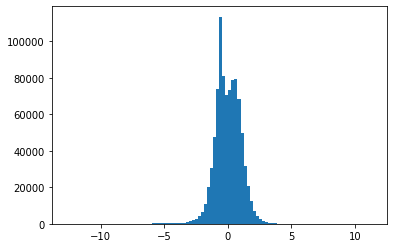

#######################################################################
DATA SPLIT
(4000, 384, 1) (4000, 384, 1)
#######################################################################
DATA LOADER
Total batch:40


In [8]:
print("#######################################################################")
print("PREPROCESS INPUTS")
X_unknown = X.copy()
X_unknown[X==unknown] = np.nan
mean = np.reshape(np.nanmean(X_unknown, axis=1), (-1,1))
std = np.reshape(np.nanstd(X_unknown, axis=1), (-1,1))
X = (X - mean)/std
X[np.isnan(X_unknown)] = unknown
print(np.max(X), np.min(X))
X_fill = (X_fill - mean)/std
print(np.max(X_fill), np.min(X_fill))

plt.hist(X[X!=unknown].flatten(), bins=100)
plt.show()

print("#######################################################################")
print("DATA SPLIT")
total_X = X_fill
total_X = np.expand_dims(total_X, axis=2)
total_Y = X
total_Y = np.expand_dims(total_Y, axis=2)

print(total_X.shape, total_Y.shape)

print("#######################################################################")
print("DATA LOADER")
class loader(Dataset):

    def __init__(self, X, y):
        self.data = X
        self.labels = y


    def __len__(self):
        return len(self.labels)

    def __getitem__(self, index):
        return self.data[index], self.labels[index]

total_data = loader(X=total_X, y=total_Y)
total_loader = torch.utils.data.DataLoader(dataset=total_data, batch_size=batch_size, shuffle=False, num_workers=0)
print("Total batch:{}".format(len(total_loader)))

# DEFINE MODEL

In [9]:
print("#######################################################################")
print("DEFINE MODEL")
class BiRNN(torch.nn.Module):
    def __init__(self, in_channels, code_dim):
        super(BiRNN,self).__init__()

        self.encoder = torch.nn.GRU(in_channels, code_dim, batch_first=True, bidirectional=True)
        self.decoder = torch.nn.GRU(in_channels, code_dim, batch_first=True)
        self.out = torch.nn.Linear(code_dim, in_channels)

        for m in self.modules():
            if isinstance(m, torch.nn.Conv2d) or isinstance(m, torch.nn.Linear):
                torch.nn.init.xavier_uniform_(m.weight)
    
    def forward(self, x):
        batch_size, seq_len, in_channels = x.shape
        
        _, code_vec = self.encoder(x)
        code_vec = torch.unsqueeze(torch.sum(code_vec, dim=0), dim=0)
        
        out = torch.zeros(batch_size, seq_len, in_channels).to(device)
        h = code_vec
        input = torch.zeros((batch_size, 1, in_channels)).to(device)
        for step in range(seq_len):
            input, h = self.decoder(input, h)
            output = self.out(input.squeeze())
            out[:,step] = output
            input = output.unsqueeze(1)
        return code_vec.squeeze(), out

#######################################################################
DEFINE MODEL


# EVALUATE MODEL

## RUN TRAINED MODEL

In [10]:
encode_vec = np.zeros((len(model_list), len(total_loader)*batch_size, code_dim)).astype(np.float32)
input_data = np.zeros((len(model_list), len(total_loader)*batch_size, time_steps, channels)).astype(np.float32)
reconstructed_data = np.zeros((len(model_list), len(total_loader)*batch_size, time_steps, channels)).astype(np.float32)

for i,mod in enumerate(model_list):
    print(i, mod)
    """build model"""
    model = BiRNN(in_channels=channels, code_dim=code_dim)
    model = model.to('cuda')
    """load model"""
    model.load_state_dict(torch.load(os.path.join(MODEL_DIR, mod)))
    model.eval()
    """run model"""
    i_encode_vec = np.zeros((len(total_loader)*batch_size, code_dim)).astype(np.float32)
    i_input_data = np.zeros((len(total_loader)*batch_size, time_steps, channels)).astype(np.float32)
    i_reconstructed_data = np.zeros((len(total_loader)*batch_size, time_steps, channels)).astype(np.float32)
    total = 0
    for batch, (data, labels) in enumerate(total_loader):
        code, out = model(data.to('cuda'))
        i_encode_vec[total:total+len(data)] = code.detach().cpu().numpy()
        i_input_data[total:total+len(data)] = labels.detach().cpu().numpy()
        i_reconstructed_data[total:total+len(data)] = out.detach().cpu().numpy()
        total += len(data)
    encode_vec[i] = i_encode_vec[:total]
    input_data[i] = i_input_data[:total]
    reconstructed_data[i] = i_reconstructed_data[:total]
encode_vec = np.mean(encode_vec, axis=0)
input_data = np.mean(input_data, axis=0)
reconstructed_data = np.mean(reconstructed_data, axis=0)
print(encode_vec.shape, input_data.shape, reconstructed_data.shape)

0 rep3_AE_2.pt
1 rep3_AE_5.pt
2 rep3_AE_4.pt
3 rep3_AE_6.pt
(4000, 64) (4000, 384, 1) (4000, 384, 1)


## RECONSTRUCTION PERFORMANCE

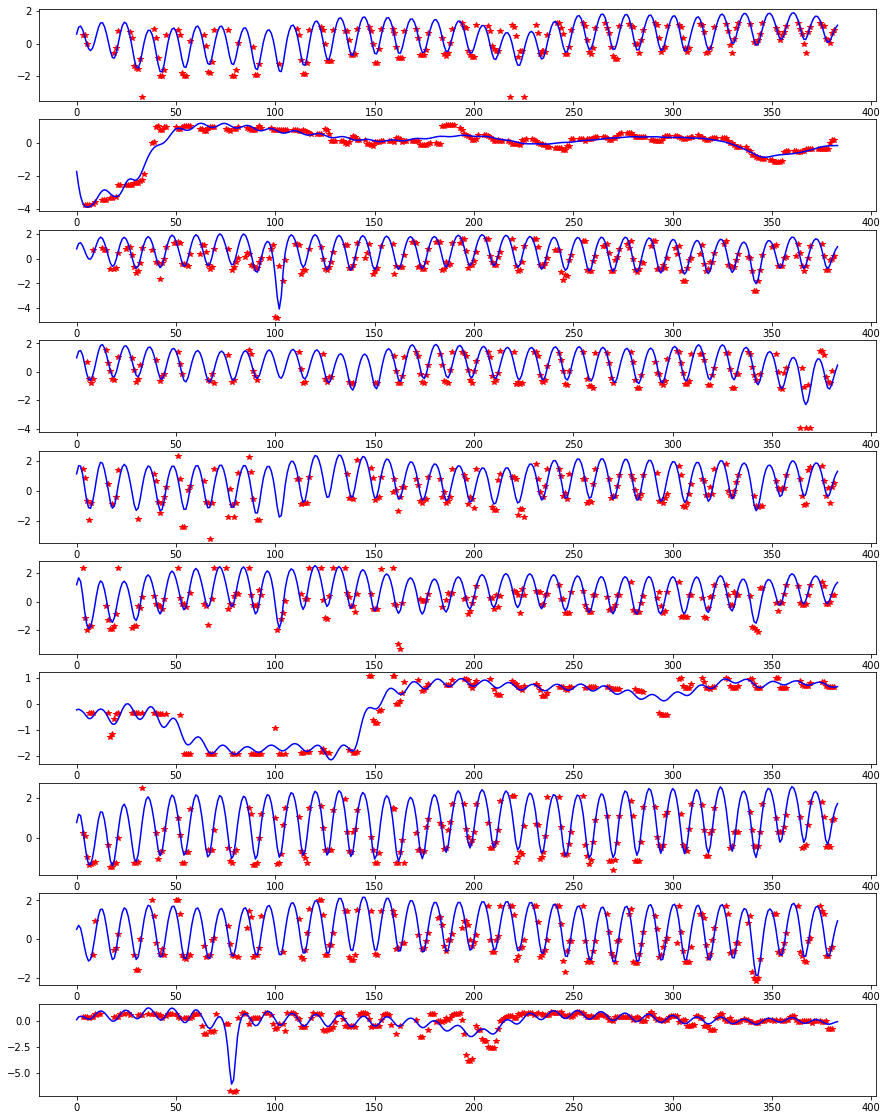

In [11]:
rows, cols = 10, 1
plt.figure(figsize=(cols*15, rows*2))
for i in range(rows*cols):
    plt.subplot(rows, cols, i+1)
    input = np.squeeze(input_data)[i]
    input[input==unknown] = np.nan
    plt.plot(input, '*r')
    plt.plot(np.squeeze(reconstructed_data)[i], "-b")

## TRAIN KMEANS


Counter({6: 228, 4: 198, 26: 169, 35: 132, 3: 129, 32: 126, 49: 126, 14: 122, 40: 121, 29: 121, 44: 120, 38: 114, 5: 111, 12: 104, 45: 92, 21: 91, 25: 90, 27: 83, 46: 83, 15: 82, 8: 81, 36: 80, 9: 78, 18: 78, 43: 75, 11: 73, 31: 66, 41: 66, 23: 66, 13: 60, 1: 58, 10: 58, 42: 51, 2: 51, 0: 51, 33: 50, 17: 50, 20: 46, 19: 45, 34: 44, 47: 42, 22: 42, 30: 40, 48: 40, 7: 36, 16: 31, 28: 30, 37: 29, 39: 26, 24: 15})


/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0, flags=flags)


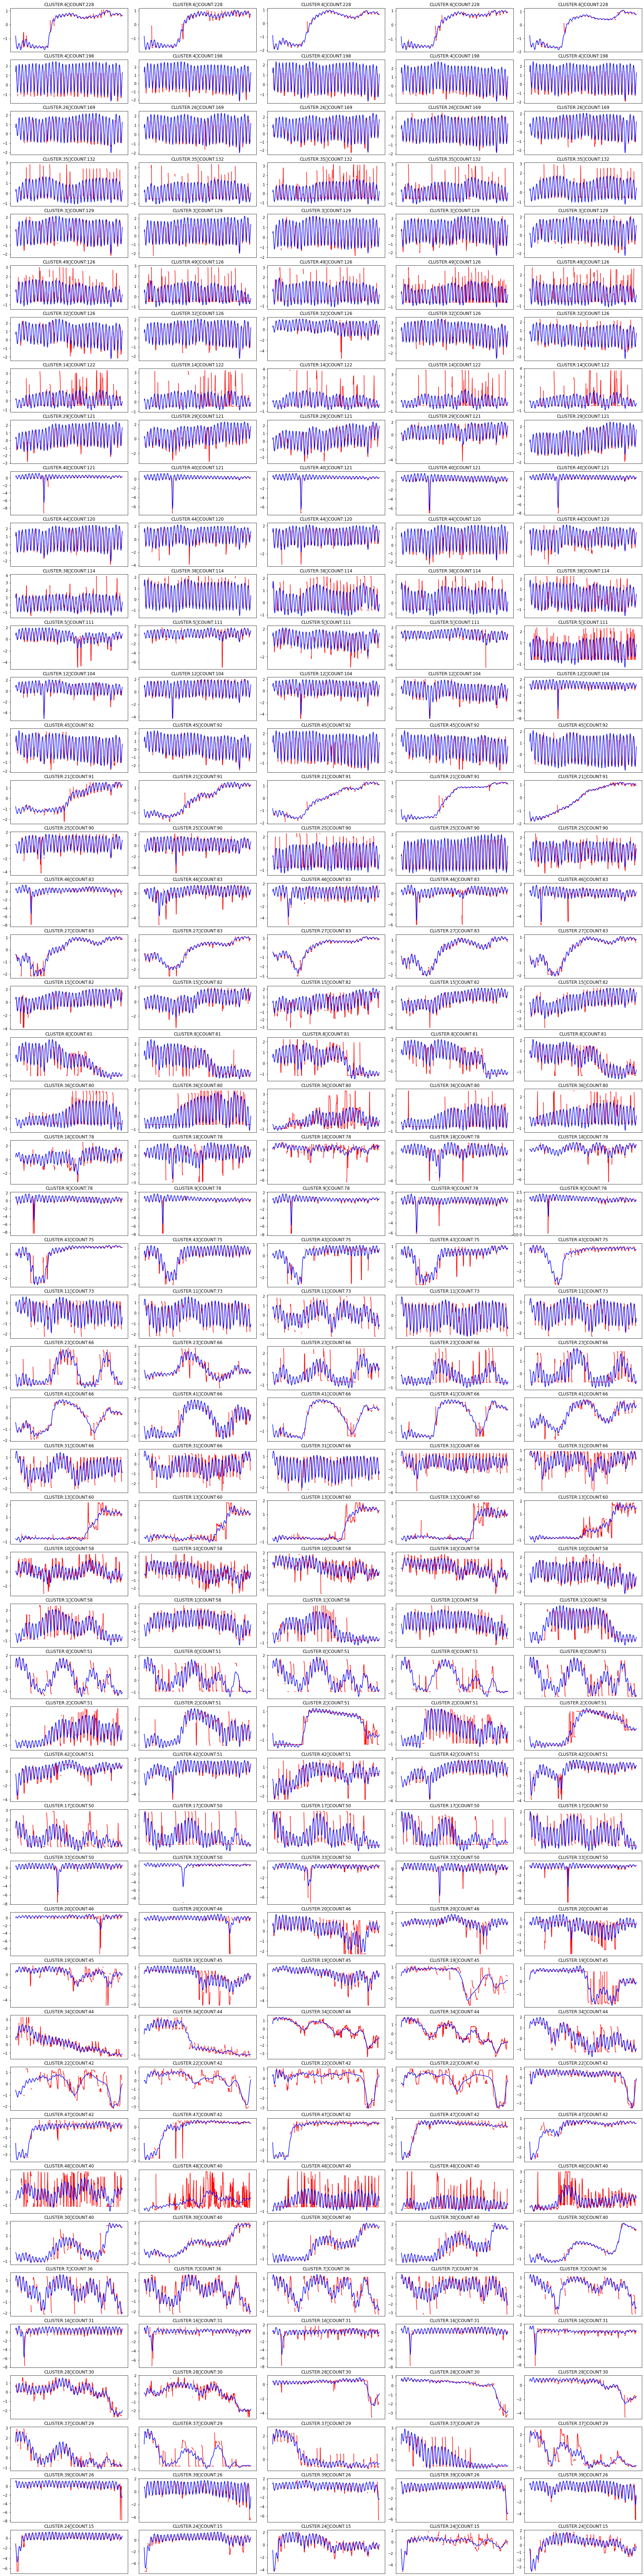

In [ ]:
kmeans = KMeans(n_clusters=n_clusters, n_init=20).fit(encode_vec)
with open(os.path.join(MODEL_DIR, "AEKMeans.p"), "wb") as f:
    pickle.dump(kmeans, f)

cluster_labels = kmeans.predict(encode_vec).astype(np.int64)
print(Counter(cluster_labels))

num_components = 5
sorted_clusters = sorted(Counter(cluster_labels), key=Counter(cluster_labels).get)[::-1]
plt.figure(figsize=(num_components*5,n_clusters*2))
for j,cluster in enumerate(sorted_clusters):
    d = kmeans.transform(encode_vec)[:, cluster]
    ind = np.argsort(d)[::][:num_components]

    for i in range(min(num_components, len(cluster_labels[cluster_labels==cluster]))):
        ax = plt.subplot(n_clusters, num_components, j*num_components+i+1)
        ax.set_title("CLUSTER:{}\tCOUNT:{}".format(cluster, len(cluster_labels[cluster_labels==cluster])))
        ax.tick_params(axis='x',bottom=False,top=False,labelbottom=False)
        input = np.squeeze(input_data[ind])[i]
        input[input==unknown] = np.nan
        ax.plot(input, '-r')
        ax.plot(np.squeeze(reconstructed_data[ind])[i], '-b')
plt.tight_layout(pad=0.0,h_pad=0.0,w_pad=0.0)
plt.savefig(os.path.join(RESULT_DIR, "Clusters.png"), format = "png")
plt.show()

#SAVE CLUSTER LABELS

In [ ]:
pd.DataFrame(cluster_labels).to_csv(os.path.join(RESULT_DIR, "y_pred_clusters_50_interp.csv"))